In [1]:
import numpy as np
import astropy as ast
import scipy as sc
import matplotlib.pyplot as plt

import numpy as np
import math
import astropy
import numpy.linalg

from tqdm import tqdm

In [2]:
import ananke as an

# reading simulations
https://www.astro.utoronto.ca/~carlberg/streams/

In [3]:
sim = '519'
ifile = 1330
simfile = './carlberg/sim'+sim+'file' + f'{ifile:04}' + '.npz'

In [4]:
npzfile= np.load(simfile)
print(npzfile.files)

['time', 'rc3', 'rs3', 'rd3', 'vc3', 'vs3', 'vd3', 'ics']


In [5]:
time = npzfile['time']
rc3 = npzfile['rc3']
rs3 = npzfile['rs3']
vs3 = npzfile['vs3']
ics = npzfile['ics']
nc = len(rc3)
print(time, nc)

14.0999999826774 271


100%|██████████| 271/271 [00:15<00:00, 17.08it/s]


Text(0, 0.5, 'v_z [km/sec]')

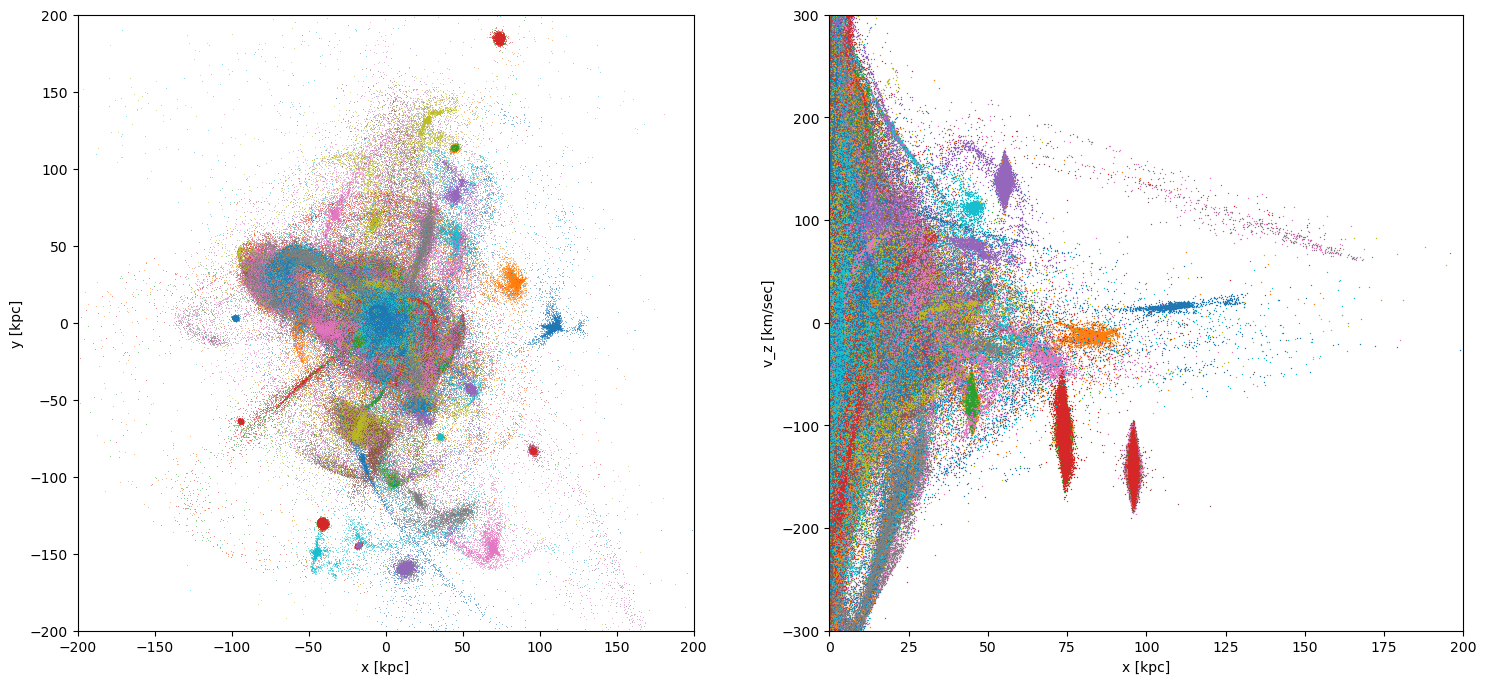

In [6]:
plt.rcParams["figure.figsize"] = (18,8)
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.set_aspect(aspect=1)

rplot = 200
vplot = 300
ax1.axis([-rplot,rplot,-rplot,rplot])

for i in tqdm(range(nc)):
    pin = ics == i
    ax1.scatter(rs3[pin, 0], rs3[pin, 1], s=0.2, lw=0)
    strip = np.abs(rs3[:, 1]) < rplot
    pin2 = pin & strip
    ax2.scatter(rs3[pin2, 0],vs3[pin2, 1],s=1,lw=0)
    
ax1.set_xlabel("x [kpc]")
ax1.set_ylabel("y [kpc]")
ax2.set_xlim(0,rplot)
ax2.set_ylim(-vplot,vplot)
ax2.set_xlabel("x [kpc]")
ax2.set_ylabel("v_z [km/sec]");

100%|██████████| 271/271 [00:00<00:00, 702.85it/s]


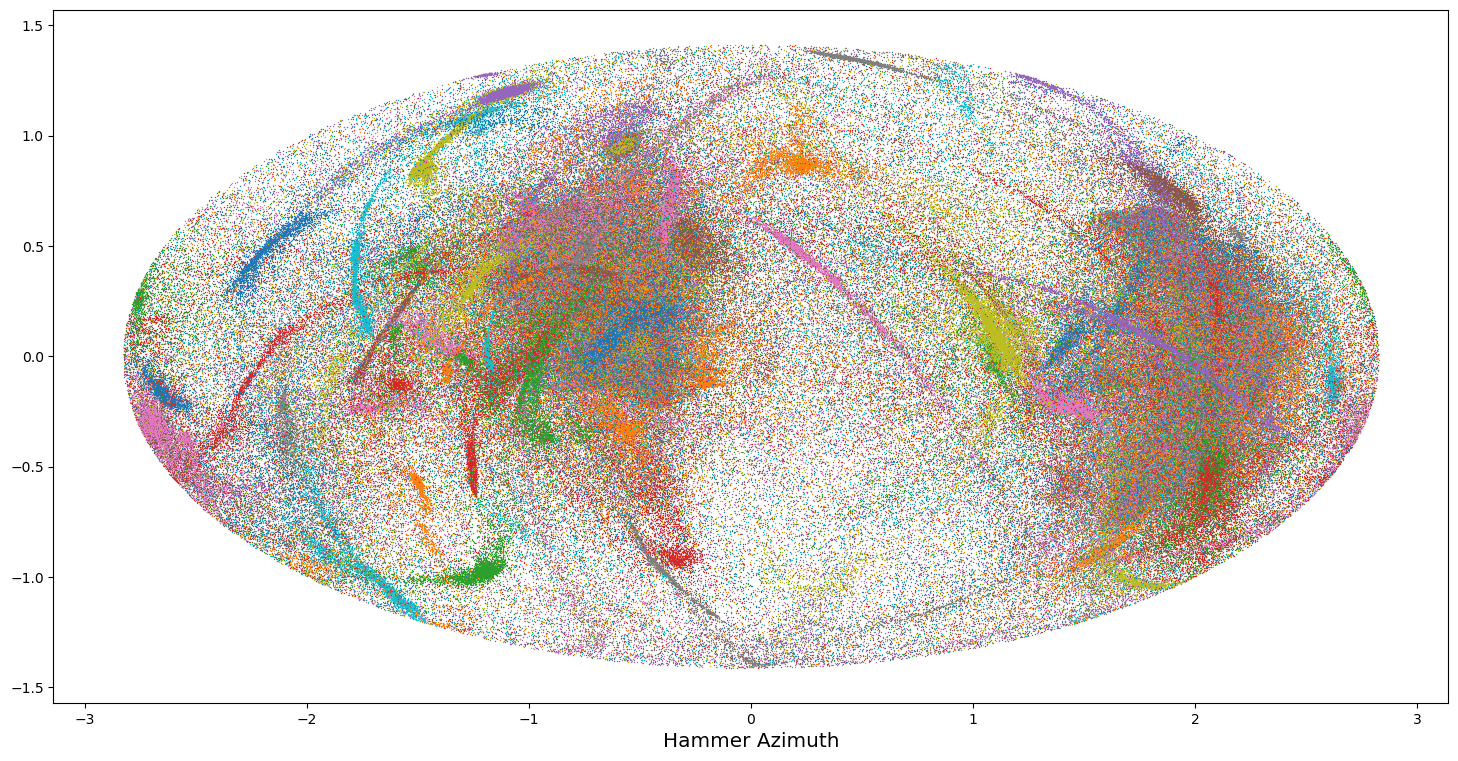

In [7]:
#np.savez(simfile,time=time,rc3=rc3,rs3=rs3,rd3=rd3,vc3=rd3,vs3=vs3,vd3=vd3,ics=ics)
dsm = np.linalg.norm(rs3, axis=1)
lon = np.arctan2(rs3[:,1],rs3[:,0])
lat = np.arcsin(rs3[:,2]/dsm)
hd = np.sqrt(1.+np.cos(lat)*np.cos(lon/2))
hx = 2.*math.sqrt(2)*np.cos(lat)*np.sin(lon/2)/hd
hy = math.sqrt(2)*np.sin(lat)/hd
dcm = np.linalg.norm(rc3,axis=1)

dmin = 10
dmax = 60
Lmin = 1000
plt.rcParams["figure.figsize"] = (18,9)
fig, (ax1) = plt.subplots()
ax1.axis([-math.pi,math.pi,-math.pi/2,math.pi/2])
ax1.set_xlabel('Hammer Azimuth',size='x-large')

for i in tqdm(range(nc)):
    dplot1 = dcm[i] > dmin
    dplot2 = dcm[i] < dmax
    if dplot1 & dplot2:
        pin = ics == i
        ax1.scatter(hx[pin],hy[pin],s=1,lw=0)

In [8]:
el_list = ['helium', 'carbon', 'nitrogen', 'oxygen', 'neon', 'magnesium', 'silicon', 'sulfur', 'calcium']

i = 120
pin = ics == i

p = {}
p['pos3'] = rs3[pin] # part['star']['host.distance'][sel]  # position in kpc
p['vel3'] = vs3[pin] # part['star']['host.velocity'][sel]  # velocity in km/s

# FIRE: star particles have an initial mass of 7070 M_sun and a typical mass of ~5000 M_sun at z=0
p['mass'] = np.ones(rs3[pin].shape[0], dtype='float32')*4.0  # mass in solar masses

# 34 metallicities from Z=0.0001(1/300thsolar) to Z=0.03(roughly twice solar) 
# 71 age values evenly spaced from log10(age yr^−1)=6.6 (3.98Myr) to log10(age yr^−1)=10.1 (12.6Gyr)
p['age'] = np.log10(np.ones(rs3[pin].shape[0], dtype='float32')* 11 * 1e9)  # log age in Gyr (also needed for isochrone sampling) -> 12Gyrs
p['feh'] = np.ones(rs3[pin].shape[0], dtype='float32')*-1.5  # [Fe/H] -> -1.5


p['alpha'] = np.ones(rs3[pin].shape[0], dtype='float32')*0.  # [Mg/Fe]
for el in el_list:  # other abundances in the list as [X/H]
    p['sulphur' if el == 'sulfur' else el] = np.ones(rs3[pin].shape[0], dtype='float32')
    
p['parentid'] = np.arange(rs3[pin].shape[0]).astype(np.float32)  # indices of parent particles in snapshot
p['dform'] = np.zeros(rs3[pin].shape[0], dtype='float32')  # dummy variable for now

In [34]:
import Galaxia

In [35]:
Galaxia.photometry.available_photo_systems

{'padova': {'LSST': Isochrone(category=padova, name=LSST),
  'HST': Isochrone(category=padova, name=HST),
  'GAIA-TYCHO-2MASS': Isochrone(category=padova, name=GAIA-TYCHO-2MASS),
  'panstarrs1': Isochrone(category=padova, name=panstarrs1),
  'SDSS': Isochrone(category=padova, name=SDSS),
  'GAIA': Isochrone(category=padova, name=GAIA),
  'UBV': Isochrone(category=padova, name=UBV),
  'DCMC': Isochrone(category=padova, name=DCMC),
  'WFIRST-LSST': Isochrone(category=padova, name=WFIRST-LSST),
  'WFIRST': Isochrone(category=padova, name=WFIRST),
  'GAIADR2': Isochrone(category=padova, name=GAIADR2),
  'WFIRST-HST': Isochrone(category=padova, name=WFIRST-HST),
  'STROEMGREN': Isochrone(category=padova, name=STROEMGREN)},
 'py_custom': {}}

In [37]:
tmp = Galaxia.photometry.available_photo_systems['padova/LSST']
tmp.mag_names

['umag', 'gmag', 'rmag', 'imag', 'zmag', 'Ymag']

# Galaxia docs 
https://galaxia.sourceforge.net/Galaxia3pub.html#mozTocId450905

In [38]:
name = 'sim'
ananke = an.Ananke(p, name, 
                   photo_sys='padova/GAIA', 
                   cmd_magnames='Gmag,Gmag-G_RPmag', 
                   fsample=1)

# app_mag_lim_lo
# app_mag_lim_hi
# abs_mag_lim_lo
# abs_mag_lim_hi
# color_lim_lo
# color_lim_hi

In [39]:
ananke.run()

Dimensions = 3
Normalization constant of Kernel type 3: 0.596831
Reading ASCII format file: to_enbid 
Read 34623 records
Allocated 0.440254 MByte for particle storage.
Type = 1 Particles = 11541
Total particles = 11541
Allocated 2.55347 MByte for Binary-Tree and Entropy bins.

Scaling Co-ordinates as x[i]=x[i]/h[i] with h[i]->
1 1 1 

Starting to Build Tree .......
Particle Type = 1 First node number = 1
                  Last node number  = 23081
Total number of nodes = 23081
Treebuild time = 0.01 s 

Density Calculation. Smoothing .....
Evaluated =   0 % Time Left = 0.000000 s of 0.000000 s Par no = 11467 Density = 1.290427e+00 
Evaluated =   1 % Time Left = 0.000000 s of 0.000000 s Par no = 7584 Density = 4.434359e-01 
Evaluated =   2 % Time Left = 0.000000 s of 0.000000 s Par no = 10707 Density = 2.976013e+09 
Evaluated =   3 % Time Left = 0.240870 s of 0.250891 s Par no = 8266 Density = 1.099805e+09 
Evaluated =   4 % Time Left = 0.190696 s of 0.200713 s Par no = 648 Density = 1.9

nbody1/sim/

	1	1

path nbody1/sim/ sats 1 x[0] 1


Using geometry:                     All Sky
setting center to 0 0 0 0 0 0
Reading Isochrones from dir-        /gpfs/gibbs/project/padmanabhan/fn234/conda_envs/cosmo/.cache/Galaxia/GalaxiaData/Isochrones/padova/GAIA
Isochrone Grid Size:                (Age bins=71,Feh bins=34,Alpha bins=1)
Time Isochrone Reading              2.84        
------------------------------
nbody1/sim/sim.ebf  Sat No=0
Particles=11541
Satellite Info
Particles=11541 Mass=46164 0.379706
Total Stars=3816 accepted=2031 rejected=1785
-----------Done---------------
Total stars written                 2031                    
30
File written-                       /vast/palmer/scratch/padmanabhan/fn234/GD/survey.sim.ebf
Calculating magnitudes in GAIA system................
initializing isochrone data
interpolating on isochrone tables
Appending spherical coordinates................
Total Time=                         2.88        
Exported the following quantities to /vast/palmer/scratch/padmanabhan/fn234/GD/survey.si

In [40]:
survey = ananke._output
tbl = survey._vaex

In [41]:
tbl

#,age,alpha,dec,dmod,feh,gaia_g_bpmag,gaia_g_rpmag,gaia_gmag,glat,glon,grav,lum,mact,mtip,parentid,partid,px,py,pz,ra,rad,smass,teff
0,10.041393280029297,0.0,75.10756,16.31857923889594,-1.5,4.5360026,3.9262607,4.3097377,13.993175,130.45197,4.345014,0.17292608,0.78447,0.8520199,0,0,-11.554475784301758,13.551562309265137,4.43795919418335,42.470066,18.353371174831825,0.7848935449535118,3.808204
1,10.041393280029297,0.0,-13.3370695,17.26180310648631,-1.5,4.6461525,4.0261984,4.41624,40.08995,342.5709,4.3727336,0.13061689,0.7771753,0.8520199,1,0,20.683795928955078,-6.493444442749023,18.249008178710938,222.96391,28.33744050312917,0.7778431010836302,3.8055048
2,10.041393280029297,0.0,-31.441914,20.993712068628124,-1.5,5.057552,4.394602,4.8085766,27.378843,280.65836,4.4679003,-0.026850624,0.7480498,0.8520199,4,0,25.954303741455078,-137.908203125,72.67401885986328,169.62466,158.0310456496246,0.748671622917405,3.7942123
3,10.041393280029297,0.0,-22.298624,17.32952141044034,-1.5,5.1824284,4.5040874,4.9266105,-78.560646,55.411945,4.4944196,-0.0747259,0.7386253,0.8520199,24,0,3.291491985321045,4.773414611816406,-28.654327392578125,1.4353138,29.23507969660401,0.7389633847654725,3.7901945
4,10.041393280029297,0.0,73.879944,16.124116961437515,-1.5,5.071471,4.4068103,4.821733,12.124914,129.21657,4.47086,-0.03216693,0.7469851,0.8520199,29,0,-10.373283386230469,12.711413383483887,3.524787425994873,35.53185,16.78121464064237,0.7475903344702406,3.7937663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2,026",10.041393280029297,0.0,73.87823,16.124394062488378,-1.5,4.5283985,3.9193616,4.3023853,12.123768,129.21844,4.3431,0.1758469,0.7849736,0.8520199,11523,0,-10.375065803527832,12.712752342224121,3.524909019470215,35.536552,16.78335622388442,0.7853803050164342,3.8083901
"2,027",10.041393280029297,0.0,73.89751,16.124806095177167,-1.5,4.284066,3.6936457,4.065886,12.141473,129.21057,4.275742,0.26965764,0.79869974,0.8520199,11524,0,-10.374600410461426,12.715744018554688,3.530649185180664,35.533005,16.786541135414783,0.799658382318608,3.813192
"2,028",10.041393280029297,0.0,85.25496,17.490527803275608,-1.5,4.834764,4.1960897,4.5959272,31.842846,122.31437,4.4182267,0.058241397,0.7652035,0.8520199,11527,0,-14.297748565673828,22.604284286499023,16.61127471923828,199.2149,31.485135063234196,0.765107127641303,3.8006835
"2,029",10.041393280029297,0.0,74.38938,16.021785146492753,-1.5,4.607691,3.9913025,4.379052,13.086643,130.22208,4.3630548,0.14539026,0.77972245,0.8520199,11531,0,-10.06917953491211,11.905978202819824,3.6247646808624268,40.20124,16.008735504840516,0.780304939515466,3.8064473
